# API demonstration for paper of v1.0

_the LSST-DESC CLMM team_


Here we demonstrate how to use `clmm` to estimate a WL halo mass from observations of a galaxy cluster when source galaxies follow a given distribution (the Chang. (2013) implemented in `clmm`). It uses several functionalities of the support `mock_data` module to produce mock datasets.

- Setting things up, with the proper imports.
- Computing the binned reduced tangential shear profile, for the 2 datasets, using logarithmic binning.
- Setting up a model accounting for the redshift distribution.
- Perform a simple fit using `scipy.optimize.curve_fit` and visualize the results.

## Setup

First, we import some standard packages.

In [990]:
import matplotlib.pyplot as plt
import numpy as np
plt.rcParams['font.family'] = ['gothambook','gotham','gotham-book','serif']

Next, we import `clmm`'s core modules.

In [991]:
import clmm
import clmm.dataops as da
import clmm.galaxycluster as gc
import clmm.theory as theory
import clmm.support.mock_data as mock
from clmm.utils import convert_units
from clmm import Cosmology

## Measuring shear profiles 

`clmm` has a support code to generate a mock catalog given a input cosmology and cluster parameters. We will use this to generate a data sample to be used in this example:

In [992]:
np.random.seed(14) # For reproducibility

# Set cosmology of mock data
cosmo = Cosmology(H0=70.0, Omega_dm0=0.27-0.045, Omega_b0=0.045, Omega_k0=0.0)

# Cluster info
cluster_m = 1.e15 # Cluster mass - ($M200_m$) [Msun]
concentration = 4  # Cluster concentration
cluster_z = 0.3 # Cluster redshift
cluster_ra = 0. # Cluster Ra in deg
cluster_dec = 0. # Cluster Dec in deg
# Make mock galaxies
mock_galaxies = mock.generate_galaxy_catalog(
    cluster_m=cluster_m, cluster_z=cluster_z, cluster_c=concentration, # Cluster data
    cosmo=cosmo, # Cosmology object
    zsrc='chang13', # Galaxy redshift distribution, 
    zsrc_min=0.4, # Minimum redshift of the galaxies
    shapenoise=0.06, # Gaussian shape noise to the galaxy shapes
    photoz_sigma_unscaled=0.05, # Photo-z errors to source redshifts
    ngals=10000 # Number of galaxies to be generated
#    ngal_density=25
)['ra', 'dec', 'e1', 'e2', 'z', 'ztrue', 'pzbins', 'pzpdf', 'id']
print(f'This results in a table with the columns: {", ".join(mock_galaxies.colnames)}')

ngals=len(mock_galaxies)
print(f'Number of galaxies: {ngals}')

good_gal = (mock_galaxies['z']>cluster_z)

# Keeping only galaxies with "measured" redshift greater than cluster redshift
if np.sum(good_gal) < ngals:
    print(f'Number of galaxies with photoz < cluster_z: {np.sum(~good_gal)}')
    mock_galaxies = mock_galaxies[good_gal]
    # reset galaxy id for later use
    mock_galaxies['id']=np.arange(np.sum(good_gal))

/pbs/home/c/ccombet/.conda/envs/mydesc3/lib/python3.7/site-packages/numpy/ma/core.py:2832: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  order=order, subok=True, ndmin=ndmin)


This results in a table with the columns: ra, dec, e1, e2, z, ztrue, pzbins, pzpdf, id
Number of galaxies: 10000
Number of galaxies with photoz < cluster_z: 15


We can extract the column of this mock catalog to show explicitely how the quantities can be used on `clmm` functionality and how to add them to a `GalaxyCluster` object: 

In [993]:
# Put galaxy values on arrays
gal_ra = mock_galaxies['ra'] # Galaxies Ra in deg
gal_dec = mock_galaxies['dec'] # Galaxies Dec in deg
gal_e1 = mock_galaxies['e1'] # Galaxies elipticipy 1
gal_e2 = mock_galaxies['e2'] # Galaxies elipticipy 2
gal_z = mock_galaxies['z'] # Galaxies observed redshift
gal_ztrue = mock_galaxies['ztrue'] # Galaxies true redshift
gal_pzbins = mock_galaxies['pzbins'] # Galaxies P(z) bins  
gal_pzpdf = mock_galaxies['pzpdf'] # Galaxies P(z)
gal_id = mock_galaxies['id'] # Galaxies ID

From the source galaxy quantities, we can compute the elepticities and corresponding radial profile usimg `clmm.dataops` functions:

In [994]:
# Convert elipticities into shears
gal_ang_dist, gal_gt, gal_gx = da.compute_tangential_and_cross_components(cluster_ra, cluster_dec,
                                                                          gal_ra, gal_dec,
                                                                          gal_e1, gal_e2,
                                                                          geometry="flat")

# Measure profile
profile = da.make_radial_profile([gal_gt, gal_gx, gal_z],
                                 gal_ang_dist, "radians", "Mpc",
                                 bins=da.make_bins(0.01, 3.7, 50),
                                 cosmo=cosmo,
                                 z_lens=cluster_z,
                                 include_empty_bins=False)
print(f'Profile table has columns: {", ".join(profile.colnames)},')
print('where p_(0, 1, 2) = (gt, gx, z)')

Profile table has columns: radius_min, radius, radius_max, p_0, p_0_err, p_1, p_1_err, p_2, p_2_err, n_src,
where p_(0, 1, 2) = (gt, gx, z)


The other possibility is to use the `GalaxyCluster` object. For that you just have to provide the following information of the cluster:

* Ra, Dec [deg]
* Mass - ($M200_m$) [Msun]
* Concentration
* Redshift


and the source galaxies:

* Ra, Dec [deg]
* 2 axis of eliptticities
* Redshift



In [995]:
# Create a GCData with the galaxies
galaxies = clmm.GCData()
galaxies['ra'] = gal_ra
galaxies['dec'] = gal_dec
galaxies['e1'] = gal_e1
galaxies['e2'] = gal_e2
galaxies['z'] = gal_z
galaxies['ztrue'] = gal_ztrue
galaxies['pzbins'] = gal_pzbins
galaxies['pzpdf'] = gal_pzpdf
galaxies['id'] = gal_id

# Create a GalaxyCluster
cluster = clmm.GalaxyCluster("Name of cluster", cluster_ra, cluster_dec,
                                   cluster_z, mock_galaxies)

# Convert elipticities into shears for the members
cluster.compute_tangential_and_cross_components(geometry="flat")
print(cluster.galcat.colnames)

# Measure profile and add profile table to the cluster
seps = convert_units(cluster.galcat['theta'], 'radians', 'mpc',cluster.z, cosmo)

cluster.make_radial_profile(bins=da.make_bins(0.1, 5, 25, method='evenlog10width'),
                            bin_units="Mpc",
                            cosmo=cosmo,
                            include_empty_bins=False,
                            gal_ids_in_bins=True,
                           )
# cluster.make_radial_profile(bins=da.make_bins(0.1, 5, 20, method='equaloccupation', source_seps=seps),
#                             bin_units="Mpc",
#                             cosmo=cosmo,
#                             include_empty_bins=False,
#                             gal_ids_in_bins=True,
#                            )


print(cluster.profile.colnames)

['ra', 'dec', 'e1', 'e2', 'z', 'ztrue', 'pzbins', 'pzpdf', 'id', 'theta', 'et', 'ex']
['radius_min', 'radius', 'radius_max', 'gt', 'gt_err', 'gx', 'gx_err', 'z', 'z_err', 'n_src', 'gal_id']


This resoults in an attribute `table` added to the `cluster` object.

[3.543307086614173, 3.543307086614173]


<Figure size 1800x1200 with 0 Axes>

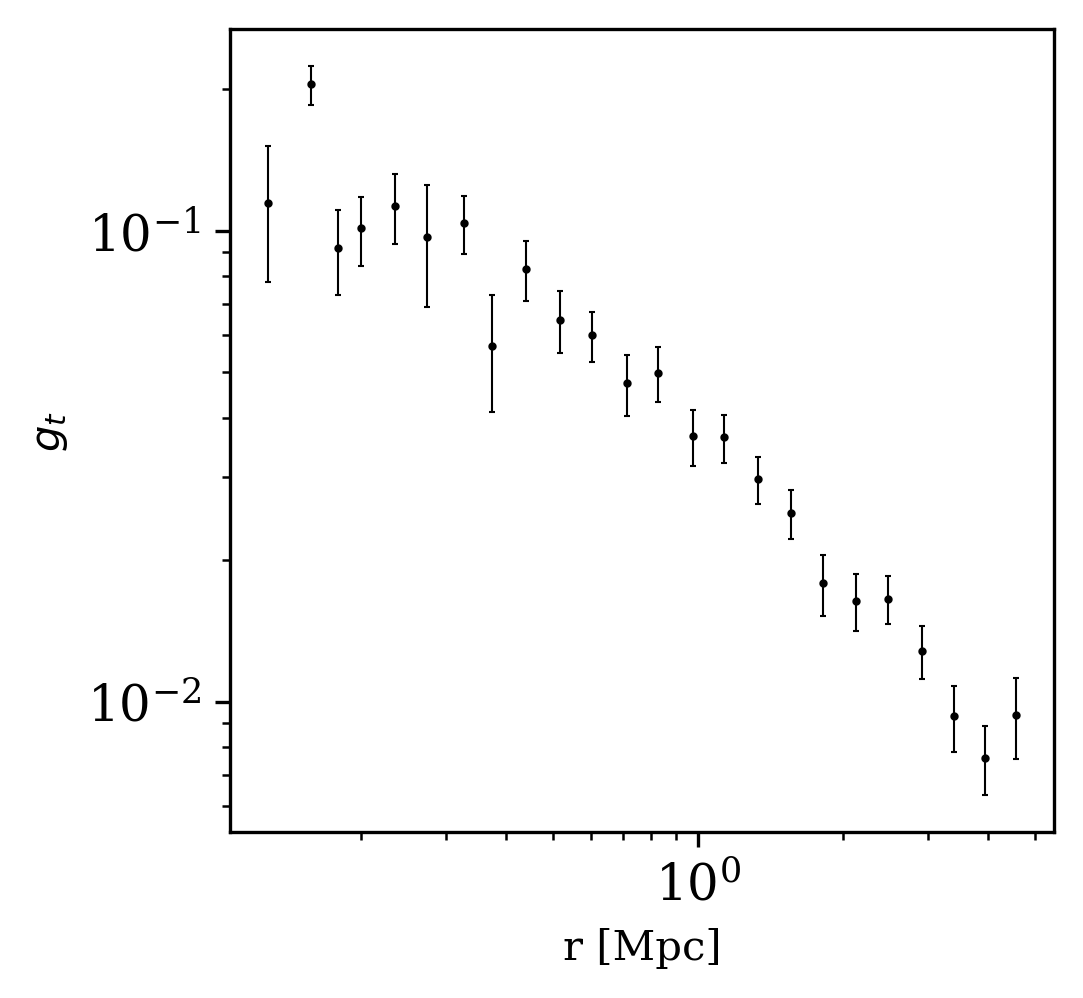

In [996]:
from paper_formating import prep_plot
prep_plot(figsize=(9, 9))
errorbar_kwargs = dict(linestyle='', marker='o',
    markersize=1, elinewidth=.5, capthick=.5)
plt.errorbar(cluster.profile['radius'], cluster.profile['gt'],
             cluster.profile['gt_err'], c='k', **errorbar_kwargs)
plt.xlabel('r [Mpc]', fontsize = 10)
plt.ylabel(r'$g_t$', fontsize = 10)
plt.xscale('log')
plt.yscale('log')

## Theoretical predictions

We consider 3 models:
1. One model where all sources are considered at the same redshift
2. One model using the overall source redshift distribution to predict the reduced tangential shear
3. A more accurate model, relying on the fact that we have access to the individual redshifts of the sources, where the average reduced tangential shear is averaged independently in each bin, accounting for the acutal population of sources in each bin.

All models rely on `clmm.predict_reduced_tangential_shear` to make a prediction that accounts for the redshift distribution of the galaxies in each radial bin:

### Model considering all sources located at the average redshift

In [997]:
def predict_reduced_tangential_shear_mean_z(profile, logm):
    return clmm.compute_reduced_tangential_shear(
            r_proj=profile['radius'], # Radial component of the profile
            mdelta=10**logm, # Mass of the cluster [M_sun]
            cdelta=4, # Concentration of the cluster
            z_cluster=cluster_z, # Redshift of the cluster
            z_source=np.mean(cluster.galcat['z']), # Mean value of source galaxies redshift
            cosmo=cosmo,
            delta_mdef=200,
            halo_profile_model='nfw'
        )

### Model relying on the overall redshift distribution of the sources, not using individual redshift information, i.e. approximate  (from Applegate et al. 2014, MNRAS, 439, 48)

In [998]:
z_inf = 1000
dl_inf = cosmo.eval_da_z1z2(cluster_z, z_inf)
d_inf = cosmo.eval_da(z_inf)

def betas(z):
    dls = cosmo.eval_da_z1z2(cluster_z, z)
    ds = cosmo.eval_da(z)
    return dls * d_inf / (ds * dl_inf)

def predict_reduced_tangential_shear_approx(profile, logm):

    bs_mean = np.mean(betas(cluster.galcat['z'])) 
    bs2_mean = np.mean(betas(cluster.galcat['z'])**2)

    gamma_t_inf = clmm.compute_tangential_shear(
            r_proj=profile['radius'], # Radial component of the profile
            mdelta=10**logm, # Mass of the cluster [M_sun]
            cdelta=4, # Concentration of the cluster
            z_cluster=cluster_z, # Redshift of the cluster
            z_source=z_inf, # Redshift value at infinity
            cosmo=cosmo,
            delta_mdef=200,
            halo_profile_model='nfw')
    convergence_inf = clmm.compute_convergence(
            r_proj=profile['radius'], # Radial component of the profile
            mdelta=10**logm, # Mass of the cluster [M_sun]
            cdelta=4, # Concentration of the cluster
            z_cluster=cluster_z, # Redshift of the cluster
            z_source=z_inf, # Redshift value at infinity
            cosmo=cosmo,
            delta_mdef=200,
            halo_profile_model='nfw')
        
    return bs_mean*gamma_t_inf/(1-(bs2_mean/bs_mean)*convergence_inf)       

### Model using individual redshift and radial information, to compute the averaged shear in each radial bin, based on the galaxies actually present in that bin.

In [999]:
cluster.galcat['theta_mpc'] = convert_units(cluster.galcat['theta'], 'radians', 'mpc',cluster.z, cosmo)

def predict_reduced_tangential_shear_exact(profile, logm):
    return np.array([np.mean(
        clmm.compute_reduced_tangential_shear(
            # Radial component of each source galaxy inside the radial bin
            r_proj=cluster.galcat[radial_bin['gal_id']]['theta_mpc'],
            mdelta=10**logm, # Mass of the cluster [M_sun]
            cdelta=4, # Concentration of the cluster
            z_cluster=cluster_z, # Redshift of the cluster
            # Redshift value of each source galaxy inside the radial bin
            z_source=cluster.galcat[radial_bin['gal_id']]['z'],
            cosmo=cosmo,
            delta_mdef=200,
            halo_profile_model='nfw'
        )) for radial_bin in profile])

## Mass fitting

We estimate the best-fit mass using `scipy.optimize.curve_fit`. The choice of fitting $\log M$ instead of $M$ lowers the range of pre-defined fitting bounds from several order of magnitude for the mass to unity. From the associated error $\sigma_{\log M}$ we calculate the error to mass as $\sigma_M = M_{fit}\ln(10)\sigma_{\log M}$.

In [1000]:
# First, identify bins with sufficient galaxy statistics to be kept for the fit (for small sample, error bars should not be 
# simply computed using the simple error on the mean approach available so far in CLMM)

points_for_fit = cluster.profile['n_src'] > 5
points_for_fit

array([False, False, False, False,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True])

In [1001]:
from clmm.support.sampler import fitters
def fit_mass(predict_function, points_for_fit):
    popt, pcov = fitters['curve_fit'](predict_function,
        cluster.profile[points_for_fit], 
        cluster.profile['gt'][points_for_fit], 
        cluster.profile['gt_err'][points_for_fit], bounds=[10.,17.])
    logm, logm_err = popt[0], np.sqrt(pcov[0][0])
    return {'logm':logm, 'logm_err':logm_err,
            'm': 10**logm, 'm_err': (10**logm)*logm_err*np.log(10)}

In [1002]:
fit_mean_z = fit_mass(predict_reduced_tangential_shear_mean_z, points_for_fit)
fit_approx = fit_mass(predict_reduced_tangential_shear_approx, points_for_fit)
fit_exact = fit_mass(predict_reduced_tangential_shear_exact, points_for_fit)

In [1003]:
print(f'The input mass = {cluster_m:.2e} Msun\n')

print(f'Best fit mass for average redshift = {fit_mean_z["m"]:.3e} +/- {fit_mean_z["m_err"]:.3e} Msun')
print(f'Best fit mass for Applegate 2014 = {fit_approx["m"]:.3e} +/- {fit_approx["m_err"]:.3e} Msun')
print(f'Best fit mass for exact redshift and radius = {fit_exact["m"]:.3e} +/- {fit_exact["m_err"]:.3e} Msun')

The input mass = 1.00e+15 Msun

Best fit mass for average redshift = 8.492e+14 +/- 3.601e+13 Msun
Best fit mass for Applegate 2014 = 9.985e+14 +/- 4.482e+13 Msun
Best fit mass for exact redshift and radius = 9.858e+14 +/- 4.088e+13 Msun


As expected, the reconstructed mass is biased when the redshift distribution is not accounted for in the model

## Visualization of the results

For visualization purpose, we calculate the reduced tangential shear predicted by the model with estimated masses for noisy and ideal data.

In [1004]:
def get_predicted_shear(predict_function, fit_values, points_for_fit):
    gt_est = predict_function(cluster.profile[points_for_fit], fit_values['logm'])
    gt_est_err = [predict_function(cluster.profile[points_for_fit], fit_values['logm']+i*fit_values['logm_err'])
                          for i in (-3, 3)]
    return gt_est, gt_est_err

In [1005]:
gt_mean_z, gt_err_mean_z =  get_predicted_shear(predict_reduced_tangential_shear_mean_z, fit_mean_z, points_for_fit)
gt_approx, gt_err_approx =  get_predicted_shear(predict_reduced_tangential_shear_approx, fit_approx, points_for_fit)
gt_exact, gt_err_exact =  get_predicted_shear(predict_reduced_tangential_shear_exact, fit_exact, points_for_fit)

We compare to tangential shear obtained with theoretical mass. We plot the reduced tangential shear models first when redshift distribution is accounted for in the model then for the naive approach, with respective best-fit masses.

[3.543307086614173, 3.543307086614173]


<Figure size 1800x1200 with 0 Axes>

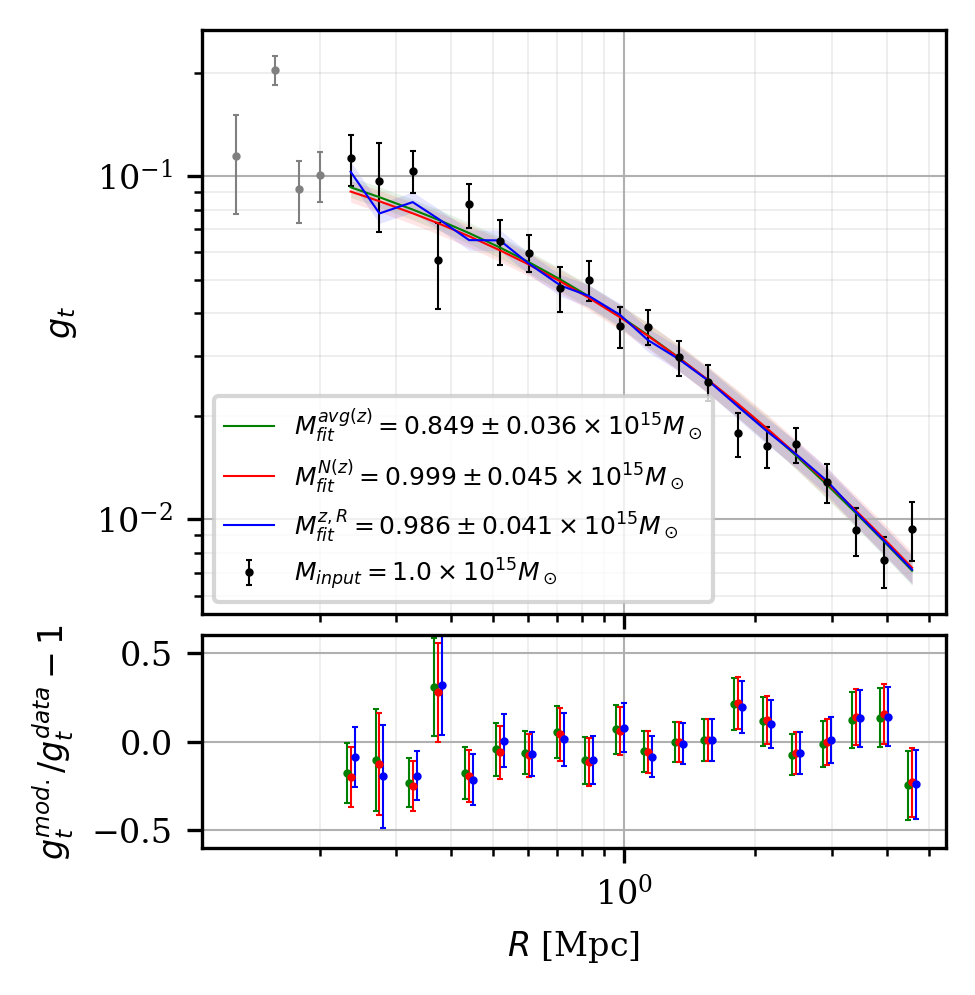

In [1006]:
from matplotlib.ticker import MultipleLocator
prep_plot(figsize=(9 , 9))
gt_ax = plt.axes([.25, .42, .7, .55])

gt_ax.errorbar(cluster.profile['radius'][points_for_fit], cluster.profile['gt'][points_for_fit], cluster.profile['gt_err'][points_for_fit],
             c='k', label=rf'$M_{{input}} = {cluster_m*1e-15}\times10^{{{15}}} M_\odot$',
            **errorbar_kwargs)

# Points in grey have not been used for the fit
gt_ax.errorbar(cluster.profile['radius'][~points_for_fit], cluster.profile['gt'][~points_for_fit], cluster.profile['gt_err'][~points_for_fit], 
               c='grey',**errorbar_kwargs)

pow10 = 15
mlabel = lambda name, fits: fr'$M_{{fit}}^{{{name}}} = {fits["m"]/10**pow10:.3f}\pm{fits["m_err"]/10**pow10:.3f}\times 10^{{{pow10}}} M_\odot$'
gt_ax.loglog(cluster.profile['radius'][points_for_fit], gt_mean_z,'-g', 
           label=mlabel('avg(z)', fit_mean_z),
          lw=.5)
gt_ax.fill_between(cluster.profile['radius'][points_for_fit], *gt_err_mean_z, lw=0, color='g', alpha=.1)

gt_ax.loglog(cluster.profile['radius'][points_for_fit], gt_approx,'-r', 
           label=mlabel('N(z)', fit_approx),
             lw=.5)
gt_ax.fill_between(cluster.profile['radius'][points_for_fit], *gt_err_approx, lw=0, color='r', alpha=.1)

gt_ax.loglog(cluster.profile['radius'][points_for_fit], gt_exact,'-b', 
           label=mlabel('z,R', fit_exact),
             lw=.5)
gt_ax.fill_between(cluster.profile['radius'][points_for_fit], *gt_err_exact, lw=0, color='b', alpha=.1)


gt_ax.set_ylabel(r'$g_t$', fontsize = 8)
gt_ax.legend(fontsize=6)
gt_ax.set_xticklabels([])
gt_ax.tick_params('x', labelsize=8)
gt_ax.tick_params('y', labelsize=8)

#gt_ax.set_yscale('log')

res_ax = plt.axes([.25, .2, .7, .2])
delta = (cluster.profile['radius'][1]/cluster.profile['radius'][0])**.1
res_ax.errorbar(cluster.profile['radius'][points_for_fit]/delta,
                gt_mean_z/cluster.profile['gt'][points_for_fit]-1,
                cluster.profile['gt_err'][points_for_fit]/cluster.profile['gt'][points_for_fit],
                c='g', **errorbar_kwargs)
res_ax.errorbar(cluster.profile['radius'][points_for_fit],
                gt_approx/cluster.profile['gt'][points_for_fit]-1,
                cluster.profile['gt_err'][points_for_fit]/cluster.profile['gt'][points_for_fit],
                c='r', **errorbar_kwargs)
res_ax.errorbar(cluster.profile['radius'][points_for_fit]*delta,
                gt_exact/cluster.profile['gt'][points_for_fit]-1,
                cluster.profile['gt_err'][points_for_fit]/cluster.profile['gt'][points_for_fit],
                c='b', **errorbar_kwargs)
res_ax.set_xlabel(r'$R$ [Mpc]', fontsize = 8)
#res_ax.set_ylabel(r'$(g_t^{model}-g_t^{data})/g_t^{data}$', fontsize = 10)
#res_ax.set_ylabel(r'$\frac{g_t^{model}-g_t^{data}}{g_t^{data}}$', fontsize = 10)
res_ax.set_ylabel(r'$g_t^{mod.}/g_t^{data}-1$', fontsize = 8)
res_ax.set_xscale('log')
res_ax.set_xlim(gt_ax.get_xlim())
res_ax.set_ylim([-0.6,0.6])
#res_ax.yaxis.set_major_locator(MultipleLocator(.04))
#res_ax.yaxis.set_minor_locator(MultipleLocator(.02))
res_ax.tick_params('x', labelsize=8)
res_ax.tick_params('y', labelsize=8)

for p in (gt_ax, res_ax):
    p.xaxis.grid(True, which='major', lw=.5)
    p.yaxis.grid(True, which='major', lw=.5)
    p.xaxis.grid(True, which='minor', lw=.1)
    p.yaxis.grid(True, which='minor', lw=.1)

plt.savefig('r_gt.png')

In [1007]:
chi2_exact_dof = np.sum((gt_exact-cluster.profile['gt'][points_for_fit])**2/(cluster.profile['gt_err'][points_for_fit])**2)/(len(points_for_fit)-1)
chi2_approx_dof = np.sum((gt_approx-cluster.profile['gt'][points_for_fit])**2/(cluster.profile['gt_err'][points_for_fit])**2)/(len(points_for_fit)-1)



In [1008]:
chi2_exact_dof

0.5811493473534003

In [1009]:
chi2_approx_dof

0.6795361703278449